# Analysis of Soil Moisture at USFS Rangeland Monitoring Sites with Python
*Author: ORNL DAAC*  
*Date: Apr. 21, 2019*  
*Contact for ORNL DAAC: uso@daac.ornl.gov*

## Summary
Forests in the western U.S. have been more and more affected by drought. For example, there was a severe drought event in the Kaibab National Forest in late 2017. The lack of precipitation on Kaibab National Forest has made 2017-2018 the second driest winter in the past 25 years. It significantly affected the biomass productivity in following years. 

<img src="https://westernnews.media.clients.ellingtoncms.com/img/photos/2018/02/20/Boundary_Fire_t715.jpg"/>

*Image source: https://www.williamsnews.com/news/2018/feb/20/dry-winter-sparks-fire-fears/*

In this tutorial, we will dynamically access soil moisture data of multiple sources (i.e. satellite, airborne, and in-situ observations) in the past 10 years from the ORNL DAAC's Soil Moisture Visualizer (https://airmoss.ornl.gov/visualize/) at selected USFS rangeland monitoring sites. We then analyze the time series trends of both surface- and rootzone-level soil moisture at the monitoring sites and compare with the time series trends of the larger USFS Regions. We will also analyze the monthly cycle of soil moisture at those rangeland monitoring sites in years 2017/2018 and compare with the historical mean monthly cycle during 2010-2016.

<img src="https://www.dropbox.com/s/33dkbz8m6tidzhy/DAAC_logo_blue_text_transparent_bg_web_0.png?dl=1" width="500"/>

The Oak Ridge National Laboratory Distributed Active Archive Center (ORNL DAAC, https://daac.ornl.gov) for biogeochemical dynamics is one of the NASA Earth Observing System Data and Information System (EOSDIS, https://earthdata.nasa.gov/about) data centers managed by the Earth Science Data and Information System (ESDIS) Project, which is responsible for providing scientific and other users access to data from NASA's Earth Science Missions. ORNL DAAC is operated by the ORNL Environmental Sciences Division and is responsible for data archival, product development and distribution, and user support for biogeochemical and ecological data and models.

ORNL DAAC archives and publishes datasets of multiple science themes collected and created by a number of NASA science missions, including the Carbon Monitoring System (CMS), Arctic-Boreal Vulnerability Experiment (ABoVE), Global Ecosystem Dynamics Investigation (GEDI) (*L3 & L4 products*), and Earth Venture Suborbital missions (CARVE, AirMOSS, ACT-America, and ATom): https://daac.ornl.gov/get_data/. 

## Earthdata Account

A NASA Earthdata account is required to access data through the Soil Moisture Visualizer (SMV). Running the cell below will prompt you for your username and password. If you do not have a NASA Earthdata, follow the link that is displayed and register before logging in.

## Choose a USFS site
*Soil Moisture Visualizer datasets are explained later.*

Two data layers from the US Forest Service:
* Forest Service Rangeland Monitoring Sites
* [Forest Service Regional Boundaries](https://enterprisecontent-usfs.opendata.arcgis.com/datasets/d5f88e90e2dd4e86b65ab51f8fe174a6_1)

Both data layers were converted from Shapefile to GeoJSON format with the GDAL/OGR [ogr2ogr](https://www.gdal.org/ogr2ogr.html) utility by OSGeo:
```
ogr2ogr -f geojson <output>.json <input>.shp
```

Click a USFS study site to submit a series of download requests to the SMV. 

In [1]:
%matplotlib widget
from ursjupyter import *
from smvjupyter import *

usfs_sites = "docs/usfs_sites/Sites_lf_geo.json"                      # USFS sites
usfs_regions = "docs/usfs_admin/USFS_admin_boundaries.json"           # USFS administrative regions

app = JupyterSMV(usfs_sites, anc=usfs_regions, session=session)

'Login successful. Download with: session.get(url)'

In [3]:

selected_layer

id                                                         3
lat                                                  34.0202
lon                                                 -109.402
layer        <smvjupyter.Layer object at 0x0000019C95987128>
samples        id        lat         lon  \
0    0  34.17...
points     LayerGroup(layers=(CircleMarker(color='white',...
xr         [SoilSCAPE_surface, SoilSCAPE_rootzone, AirMOS...
Name: 3, dtype: object

In [ ]:
selected_layer = app.layers.iloc[app.selected]
ds = selected_layer.xr.sel(stat="Mean", drop=True)
ds

### Some plot settings
*Note: changing plotting mode to inline disables interactivity.*

In [40]:
p = Plotter(selected_layer)
p.ui

In [ ]:
%matplotlib inline
plt.rc('font', **{'family': 'normal', 'weight': 'normal', 'size': 14})
plt.rc("axes", **{"xmargin": 0.01})

### Summary stats for southwest USFS administrative region

Pre-calculated using the same workflow as demonstrated towards the bottom of this notebook:

In [ ]:
usfs_astats = pd.read_csv("docs/usfs_admin.csv", index_col="time")
usfs_astats.index = pd.to_datetime(usfs_astats.index)
usfs_astats.head(5)

In [ ]:
plotters = [(0, "smap_rz", "darkgreen", "SMAP_rootzone"), 
            (0, "smap_su", "darkgreen", "SMAP_surface")]#,
            #(0, "insitu_rz", "darkorange", "in situ"), 
            #(1, "insitu_su", "darkorange", "in situ")]
xtime = usfs_astats.index

fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(18,8))
fig.tight_layout()

for i, p in enumerate(plotters):
    
    #dsweek = p[0].resample(time="1w").mean(keep_attrs=True)
    #dscat = xr.concat(dsweek.values(), "sample")
    axnum, prefix, clr, name = p
    
    dsmean = usfs_astats[prefix+"_mean"]
    dsstd = usfs_astats[prefix+"_std"]
    stdlo, stdhi = (dsmean-dsstd), (dsmean+dsstd)

    ax = axs[axnum]
    dsmean.plot.line(x=xtime, y=dsmean, ax=ax, color=p[2], label=name, linestyle="--")
    ax.fill_between(xtime, stdlo, stdhi, color=p[2], alpha=0.2)
    
st, et = xtime[0], xtime[-1]
usfs_stats = selected_layer.layer.stats.loc[st:et]
usfs_stats["STDH"] = usfs_stats.MEAN+usfs_stats.STD
usfs_stats["STDL"] = usfs_stats.MEAN-usfs_stats.STD

usfs_stats.MEAN.plot(ax=axs[1], color="black")
#axs[1].fill_between(usfs_stats.index, usfs_stats.STDL, usfs_stats.STDH, color=p[2], alpha=0.2)
(usfs_stats.MEAN+usfs_stats.STD).plot(ax=axs[1], color="black", linestyle=":")
(usfs_stats.MEAN-usfs_stats.STD).plot(ax=axs[1], color="black", linestyle=":")

axs[0].set_title("Volumetric soil moisture from SMAP for southwest USFS administrative region")
axs[1].set_title("USFS Gross Primary Productivity (units)")
axs[0].grid("on", alpha=0.2); axs[1].grid("on", alpha=0.2)
axs[0].legend(loc="upper left")
axs[0].set_ylabel("m3/m3")
axs[0].set_xlabel(None)
axs[0].set_ylim(0,30)

plt.show()

### Volumetric soil moisture by depth zone (surface, rootzone) for each platform type

In [ ]:
plotters = [
    (ds.filter_by_attrs(type="in situ", soil_zone="rootzone"), 0, "darkorange"),
    (ds.filter_by_attrs(type="airborne", soil_zone="rootzone"), 0, "darkblue"),
    (ds.filter_by_attrs(type="spaceborne", soil_zone="rootzone"), 0, "darkgreen"),
    
    (ds.filter_by_attrs(type="in situ", soil_zone="surface"), 1, "darkorange"),
    (ds.filter_by_attrs(type="airborne", soil_zone="surface"), 1, "darkblue"),
    (ds.filter_by_attrs(type="spaceborne", soil_zone="surface"), 1, "darkgreen")
]

fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(18,8))
fig.tight_layout()
plt.subplots_adjust(hspace=0.000)

for i, p in enumerate(plotters):
    
    dsweek = p[0].resample(time="1w").mean(keep_attrs=True)
    dscat = xr.concat(dsweek.values(), "sample")
    
    dsmean = dscat.mean("sample", keep_attrs=True) 
    dsstd = dscat.std("sample", keep_attrs=True)
    stdlo, stdhi = (dsmean-dsstd), (dsmean+dsstd)
    
    if not all(dsmean.isnull()):
        
        ax = axs[p[1]]
        desc = dsmean.attrs["type"]
        zone = dsmean.attrs["soil_zone"]
        
        dsmean.plot.line(x="time", ax=ax, color=p[2], label=desc, linestyle="--")
        ax.fill_between(dsmean.time.data, stdlo, stdhi, color=p[2], alpha=0.2)
        ax.set_ylabel(zone+" (m3/m3)")


axs[0].set_title("Vol. soil moisture by platform type (in situ, airborne, spaceborne)")
axs[0].grid("on", alpha=0.2); axs[1].grid("on", alpha=0.2)
axs[0].legend(loc="upper left"); axs[1].legend(loc="upper left")
axs[0].set_xlabel(None)

plt.show()

## Soil Moisture Visualizer (SMV) datasets

### Soil Moisture Active Passive (SMAP)
Four SMAP datasets are available through the Soil Moisture Visualizer (SMV):
* Root zone (0-100cm) volumetric soil moisture (m3/m3)
* Surface zone (0-5cm) volumetric soil moisture (m3/m3)
* Gross Primary Productivity (g m-2 d-1)
* Net Ecosystem Exchange (g m-2 d-1)

This plot shows the time series of SMAP datasets averaged over the 58 SMV sample locations covering the area of USFS site 1:

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(18, 12))
fig.tight_layout()
plt.subplots_adjust(hspace=0.000)

smap = ds.filter_by_attrs(source="SMAP")                                        # get SMAP datasets

for p in [("SMAP_surface", 0, "black"), ("SMAP_rootzone", 1, "black"), 
          ("GPP_mean", 2, None), ("NEE_mean", 2, None)]:
    ax = axs[p[1]]
    data = smap[p[0]]
    desc = data.attrs["description"]
    
    ptime = data.time.data
    pmean = data.mean("sample", keep_attrs=True)
    pstd = data.std("sample", keep_attrs=True)
    
    pmean.plot.line(x="time", ax=ax, label=desc, add_legend=False, color=p[2])
    ax.fill_between(ptime, (pmean-pstd), (pmean+pstd), color="gray", alpha=0.2)

for i, a in enumerate(axs):
    ylab = "m3/m3" if i<2 else "g m-2 d-1"
    a.set_ylabel(ylab)
    a.set_xlabel(None)
    a.grid('on', alpha=0.25)
    a.legend(loc=0, framealpha=1)
    
axs[0].set_title("SMAP: Soil moisture at rootzone (1) and surface (2) depths; GPP and NEE (3)")

### Airborne Microwave Observatory of Subcanopy and Subsurface (AirMOSS)

Five AirMOSS datasets are available through the SMV:
* Mean vol (%) soil moisture at 0-5 cm (from in-ground sensors)
* Mean vol (%) soil moisture at 0-100 cm (from in-ground sensors)
* Mean vol (%) soil moisture at 0 cm (from L2 airborne SAR)
* Mean vol (%) soil moisture at 0-30cm (from L2 airborne SAR)
* Mean vol (%) soil moisture at 0-100cm	(from L2 airborne SAR)

In [ ]:
airmoss = ds.filter_by_attrs(source="AirMOSS")
airmoss

AirMOSS data are relatively sparse. The only one suitable for plotting a time series is the level rootzone soil moisture:

In [ ]:
airmoss = ds.filter_by_attrs(source="AirMOSS")

if xr.concat(airmoss.isnull().values(), "null_check").data.all():
    print("No AirMOSS observations for this site!")
else:
    
    data = airmoss["AirMOSS_L4_rootzone"]
    ptime = data.time.data
    pmean = data.mean("sample", keep_attrs=True)
    pstd = data.std("sample", keep_attrs=True)

    fig = plt.figure(figsize=(18, 4))
    ax = plt.gca()
    pmean.plot.line(x="time", ax=ax, label=desc, add_legend=False)
    ax.fill_between(ptime, (pmean-pstd), (pmean+pstd), color="gray", alpha=0.2)
    ax.set_title("AirMOSS_L4_rootzone: "+data.attrs["description"])
    ax.set_ylabel(data.attrs["units"])
    ax.grid("on", alpha=0.25)

### Daymet

Three Daymet datasets are available through the SMV: daily precipitation, minimum and maximum temperature.

In [ ]:
fig, ax0 = plt.subplots(figsize=(14,5))
fig.tight_layout()
ax1 = ax0.twinx()

daymet = ds.filter_by_attrs(source="Daymet")
prcp = daymet.prcp.resample(time="1m", keep_attrs=True).mean(keep_attrs=True).to_series() # avg precip over 1month
tmin = daymet.tmin.resample(time="1w", keep_attrs=True).mean(keep_attrs=True)             # avg tmin over 1week
tmax = daymet.tmax.resample(time="1w", keep_attrs=True).mean(keep_attrs=True)             # avg tmax over 1week

l1 = tmin.plot(ax=ax0, color="darkgreen", label="Min temperature weekly average")
l2 = tmax.plot(ax=ax0, color="darkorange", label="Max temperature weekly average")
ax1.bar(prcp.index, prcp, width=25, alpha=0.5, label="Daily precipitation monthly average")

ax0.grid("on", alpha=0.5)
ax0.set_ylabel(tmin.attrs["units"])
ax1.set_ylabel(daymet.prcp.attrs["units"])
ax0.legend(loc="upper left"); ax1.legend()
ax0.set_title("Daymet surface meteorology: tmin, tmax, prcp")

### Rootzone and surface soil moisture
Soil moisture data are provided for two general depth zones: rootzone and surface:

In [ ]:
soil_moisture = ds.filter_by_attrs(units="m3/m3")
rootzone = soil_moisture.filter_by_attrs(soil_zone="rootzone")
surface = soil_moisture.filter_by_attrs(soil_zone="surface")

Plot all of the soil moisture observations and the means for both soil depths:

In [ ]:
fig, axs = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(16, 12))
fig.tight_layout()
plt.subplots_adjust(hspace=0.000)

for plotter in [(0, "rootzone", rootzone), (2, "surface", surface)]:
    axa, axb = axs[plotter[0]+1], axs[plotter[0]]
    
    arrays, clrs = [], get_colors(len(plotter[2]), cmap=cm.Dark2)
    for i, dataset in enumerate(plotter[2].values()):
        name = dataset.name
        data = dataset.mean("sample") if "sample" in dataset.dims else dataset
        if not all(data.isnull()):
            data.plot.line(ax=axa, x="time", label=name, color=clrs[i], add_legend=False)
            arrays.append(dataset)

    stack = xr.concat(arrays, "mean").stack(cat=("mean", "sample"))
    pmean, pstd = stack.mean("cat"), stack.std("cat")
    pmean.plot(x="time", ax=axb, color="black", label=plotter[1]+" mean")
    axb.fill_between(pmean.time.data, (pmean-pstd), (pmean+pstd), color="gray", alpha=0.2)

    axa.legend(loc=2); axb.legend(loc=1)
    #axa.set_ylim(0, 35); axb.set_ylim(0, 35)
    axa.set_xlabel(None); axb.set_xlabel(None)
    axa.grid("on", alpha=0.25); axb.grid("on", alpha=0.25)
    axb.set_ylabel(plotter[1]); axa.set_ylabel("(m3/m3)")

axs[0].set_title("All rootzone (1,2) and surface (3,4) soil moisture observations")

### Summarize the rootzone soil moisture over all sample locations

Concatenate all of the rootzone soil moisture datasets, add some time coordinates to the dataset, and select years 2010 to 2019:

In [ ]:
ds_2012_2019 = ds.sel(time=slice(str(2012),str(2019)))

ds_2012_2019.coords["year"] = ds_2012_2019.time.dt.year         # add year coordinate
ds_2012_2019.coords["month"] = ds_2012_2019.time.dt.month       # add month coordinate               
ds_2012_2019.coords["day"] = ds_2012_2019.time.dt.dayofyear     # add doy coordinate

rootzone = ds_2012_2019.filter_by_attrs(soil_zone="rootzone")
rzmean = rootzone.mean("sample", keep_attrs=True)               # calc mean over sample dimension
rzcat = xr.concat(rzmean.values(), "cat").mean("cat")           # concat all variable arrays and average
rzcat

Group by month and plot:

In [ ]:
fig = plt.figure(figsize=(18, 5))                              # init figure
ax = plt.gca()                                                 # get figure axes

rz_mo = rzcat.groupby("month")                                 # group by month
mo_mean, mo_std = rz_mo.mean(), rz_mo.std()                    # calc mean, standard deviation
mo_stdlow, mo_stdhi = (mo_mean-mo_std), (mo_mean+mo_std)       # get std bounds

# plot mean, then standard deviation
l1 = mo_mean.plot.line(ax=ax, x="month", label="soil moisture", linestyle="--", color="black")
s1 = ax.fill_between(mo_mean.month, mo_stdlow, mo_stdhi, color="gray", alpha=0.2)

# also get SMAP GPP mean by month       
gpp = ds_2012_2019["GPP_mean"].mean("sample", keep_attrs=True) # calc mean over sample dim 
gpp_mo = gpp.groupby("month")                                  # group by day
gpp_mean, gpp_std = gpp_mo.mean(), gpp_mo.std()                # get mean, std
gpp_stdlow, gpp_stdhi = (gpp_mean-gpp_std), (gpp_mean+gpp_std) # get std bounds

# add another y axis to the second plot and plot mean, then standard deviation
ax2 = ax.twinx()  
l2 = gpp_mean.plot.line(ax=ax2, x="month", label="productivity", color="midnightblue")
s2 = ax2.fill_between(gpp_mean.month, gpp_stdlow, gpp_stdhi, color="midnightblue", alpha=0.2)

po = l1+l2
labels = [o.get_label() for o in po]
ax.legend(po, labels, loc=1)

ax.grid("on", alpha=0.5)                                       # some plot settings
#ax.set_ylim(10, 25); ax2.set_ylim(0, 4)
ax.set_title("monthly vol. soil moisture by year (0-100cm; all sources)") 
ax.set_ylabel("Soil moisture (m3/m3)"); ax2.set_ylabel("SMAP GPP (g m-2 d-1)")

Or by day of the year:

In [ ]:
fig = plt.figure(figsize=(18, 5))                                                   # init figure
ax = plt.gca()                                                                      # get figure axes

rz_day = rzcat.groupby("day")                                                       # group by day
day_mean, day_std = rz_day.mean(), rz_day.std()                                     # get mean, std
day_stdlow, day_stdhi = (day_mean-day_std), (day_mean+day_std)                      # get std bounds

for yr in np.unique(rzcat.year.data):                                               # loop over years
    ln = rzcat.sel(time=str(yr)).groupby("day").mean()                              # average by day 
    ln.plot.line(x="day", label=str(yr), ax=ax, alpha=0.75)                          # plot

# plot mean, then standard deviation
day_mean.plot.line(ax=ax, x="day", label="mean", linestyle="--", color="black")
ax.fill_between(day_mean.day, day_stdlow, day_stdhi, color="gray", alpha=0.2)

# some plot settings
ax.set_title("daily vol. soil moisture by year (0-100cm; all sources)")
ax.legend(loc=1, bbox_to_anchor=(1.15, 1))
ax.set_ylabel("rootzone (m3/m3)")
ax.set_xlabel("day of the year")
ax.grid("on", alpha=0.5)

# In situ, airborne soil moisture observations for all datasets
The aggregation and harmonization of the various soil moisture datasets gives flexibility for a wide range of implementation scenarios. The next cell plots the average through time of all in situ and airborne soil moisture datasets available through the SMV. The two sets of data can be selection from the big `xarray` dataset with a few methods:
* select datasets with *in situ* and *airborne* for the *type* attribute
* select the *Mean* statistic from the *stat* dimension and the desired site from the *site* dimension
* average the remaining data over the *sample* dimension

Here's how it looks in practice:

In [ ]:
insitu = ds.filter_by_attrs(type="in situ")                # select in situ, and
airborne = ds.filter_by_attrs(type="airborne")             # airborne datasets
spaceborne = ds.filter_by_attrs(type="spaceborne")         # spaceborne datasets

fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(18, 8))
fig.tight_layout()
plt.subplots_adjust(hspace=0.000)

plotters = [(insitu, axs[0], "In situ"), 
            (airborne, axs[1], "Airborne"),
            (spaceborne, axs[2], "Spaceborne")]

for p in plotters:
    data, ax, title = p
    data = data.mean(dim="sample")                          # select stat "Mean" and site N. avg sample dim
    tmpstack = np.stack([data[v].data for v in data])       # collapse dataset into a stacked array
    tmpmean = np.nanmean(tmpstack, axis=0)                  # calculate mean over time axis (0)
    tmpstd = np.nanstd(tmpstack, axis=0)                    # calculate mean over time axis (0)
    tmptime = data.time.data

    ax.plot_date(x=tmptime, y=tmpmean, color="black", linestyle="solid", marker=None)
    ax.fill_between(tmptime, (tmpmean-tmpstd), (tmpmean+tmpstd), color="gray", alpha=0.2)
    ax.set_ylabel(title)
    ax.grid('on', alpha=0.25)

axs[0].set_title("Time series avg of all available soil moisture data (m3/m3)")
plt.show()

### Rootzone moisture ONLY (0-100 cm depth) & USFS site productivity (GPP)

In [ ]:
rootzone = ds.filter_by_attrs(soil_zone="rootzone") 
time = rootzone.time.data

insitu = rootzone.filter_by_attrs(type="in situ")              # select in situ, and
airborne = rootzone.filter_by_attrs(type="airborne")           # airborne datasets
spaceborne = rootzone.filter_by_attrs(type="spaceborne")       # spaceborne datasets

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))

#st, et = time[0], time[-1]
#usfs_stats = selected_layer.layer.stats.loc[st:et]
#usfs_mean, usfs_std = usfs_stats.MEAN, usfs_stats.STD
#stdlo, stdhi = (usfs_mean-usfs_std), (usfs_mean+usfs_std)   # get std bounds
#usfs_stats.MEAN.plot(ax=axs[0])

# plot soil moisture
plotters = [(insitu, "in situ", "darkorange"), 
            (airborne, "airborne", "darkblue"),
            (spaceborne, "spaceborne", "darkgreen")]

for p in plotters:
    data, title, clr = p
    data = data.mean(dim="sample")                          # select stat "Mean" and site N. avg sample dim
    dscat = xr.concat(data.values(), "cat")
    dsmean, dsstd = dscat.mean("cat"), dscat.std("cat")
    dsmean.plot.line(x="time", ax=axs[1], label=title, color=clr)

axs[0].set_xlim(axs[1].get_xlim())

axs[1].set_ylabel("m3/m3")
axs[1].legend(loc="lower left")
axs[1].grid('on', alpha=0.25); axs[0].grid('on', alpha=0.25)
axs[1].set_title("Time series avg of all ROOTZONE soil moisture data")

plt.show()

# Detailed walkthrough
Steps below explain how we request the SMV data and construct the dataset from a list of sample locations.


## Requirements

### Python
Written and tested in Python3. Should be compatible with Python2 with minor changes.

* [numpy](https://www.numpy.org/) --- fundamental Python module for processing n-dimensional arrays and for scientific computing in general
* [pandas](https://pandas.pydata.org/) --- tabular data structures and analysis tools built on numpy
 (and to a lesser degree [dask](https://dask.org/)) that support labeled dimensions, coordinates, and attributes for geodata

Fundamental python science libraries. `numpy` for numeric arrays; `pandas` for table structure 

* [xarray](http://xarray.pydata.org/en/stable/) --- ndimensional labeled arrays, works like pandas
* [requests](https://2.python-requests.org/en/master/) --- high-level library for sending HTTP requests; alternatives: urllib/urllib2
* [shapely](https://shapely.readthedocs.io/en/latest/project.html) --- python geometric analysis based on [GEOS](https://trac.osgeo.org/geos/)
* [matplotlib](https://matplotlib.org/) --- 2D plotting; `pandas` and `xarray` have `matplotlib` built-in; 

* io, json --- base python; `io.StringIO` is `StringIO.StringIO` in python 2

In [9]:
%matplotlib inline
import os
import json
from math import ceil
from io import StringIO
from datetime import datetime

import requests
import numpy as np
import pandas as pd
import xarray as xr
from shapely.geometry import shape

## Soil Moisture Visualizer

The [table (docs/smvdatasets.csv)](docs/smvdatasets.csv) included in this repo is a copy of the datasets table from the [SMV User Guide](https://daac.ornl.gov/soilmoisture/guide.html). Read it into a data frame using [`pandas.read_csv`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) and display the available datasets:

In [3]:
smv_datasets = pd.read_csv("docs/smvdatasets.csv", index_col="dataset", header=0)
smv_datasets

,source,type,units,description,soil_zone,soil_depth,native_res,time_coverage
dataset,,,,,,,,
SoilSCAPE_surface,SoilSCAPE,in situ,m3/m3,Mean vol (%) soil moisture at 0-5 cm,surface,"5, 20, 50 cm",point,2011-present
SoilSCAPE_rootzone,SoilSCAPE,in situ,m3/m3,Mean vol (%) soil moisture at 0-100 cm,rootzone,"5, 20, 50 cm",point,2011-present
AirMOSS_in-ground_surface,AirMOSS,in situ,m3/m3,Mean vol (%) soil moisture at 0-5 cm,surface,"2, 5, 10, 20, 40, 60, 80 cm",point,2012-2015
AirMOSS_in-ground_rootzone,AirMOSS,in situ,m3/m3,Mean vol (%) soil moisture at 0-100 cm,rootzone,"2, 5, 10, 20, 40, 60, 80 cm",point,2012-2015
COSMOS_surface,COSMOS,in situ,m3/m3,Mean vol (%) soil moisture at 0-5 cm,surface,0-30 cm,point,2008-present
COSMOS_rootzone,COSMOS,in situ,m3/m3,Mean vol (%) soil moisture at 0-100 cm,rootzone,0-30 cm,point,2008-present
AirMOSS_L2_3_surface,AirMOSS,airborne,m3/m3,Mean vol (%) soil moisture at 0 cm,surface,"0, 10, 30 cm",90-m,2012-2015
AirMOSS_L2_3_rootzone,AirMOSS,airborne,m3/m3,Mean vol (%) soil moisture at 0-30cm,rootzone,"0, 10, 30 cm",90-m,2012-2015
AirMOSS_L4_rootzone,AirMOSS,airborne,m3/m3,Mean vol (%) soil moisture at 0-100cm,rootzone,"0-10, 10-40, 40-100 cm",90-m,2012-2015


The datasets are updated weekly (every Sunday), but some data sets may have a longer latency period.

Start by opening an example dataset from the included [text file](docs/daily-smap-ORNL-DAAC-PccIuo.txt). We use `pandas.read_csv` again, skipping to the fourth line and setting the data frame index to the column labeled *time*:

In [5]:
df = pd.read_csv("docs/daily-smap-ORNL-DAAC-hYa36V.txt", header=4, index_col="time")
df.index = pd.to_datetime(df.index)   

df.head(5)

,SoilSCAPE_surface,SoilSCAPE_rootzone,AirMOSS_L2_3_surface,AirMOSS_L2_3_rootzone,AirMOSS_L4_rootzone,SMAP_surface,SMAP_rootzone,NEE_mean,GPP_mean,prcp,...,CRN_surface,CRN_rootzone,SCAN_surface,SCAN_rootzone,SNOTEL_surface,SNOTEL_rootzone,GRACE_surface_pctl,GRACE_rootzone_pctl,FLUXNET_surface,FLUXNET_rootzone
time,,,,,,,,,,,,,,,,,,,,,
1999-03-22,nan;nan;nan,nan;nan;nan,;;,;;,;;,;;,;;,;;,;;,;;,...,;;,;;,1.0;3.05;5.1,1.0;5.5;9.2,;;,;;,;;,;;,;;,;;
1999-03-23,nan;nan;nan,nan;nan;nan,;;,;;,;;,;;,;;,;;,;;,;;,...,;;,;;,0.8;3.0;5.2,0.8;5.6;9.4,;;,;;,;;,;;,;;,;;
1999-03-24,nan;nan;nan,nan;nan;nan,;;,;;,;;,;;,;;,;;,;;,;;,...,;;,;;,3.0;3.8;4.6,3.0;6.0;9.7,;;,;;,;;,;;,;;,;;
1999-03-25,nan;nan;nan,nan;nan;nan,;;,;;,;;,;;,;;,;;,;;,;;,...,;;,;;,1.0;3.35;5.7,1.0;5.72;9.7,;;,;;,;;,;;,;;,;;
1999-03-26,nan;nan;nan,nan;nan;nan,;;,;;,;;,;;,;;,;;,;;,;;,...,;;,;;,3.9;4.65;5.4,3.9;6.28;9.7,;;,;;,;;,;;,;;,;;


The text file is parsed to a data frame with up to three values per column, delimited by semicolons `;`: min, mean, and max. Do some additional data preparation in the following steps:

1. Use [`pandas.Series.str.split`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.split.html) to split each column into three columns;
2. replace the empty strings with [`numpy.nan`](https://docs.scipy.org/doc/numpy-1.13.0/user/misc.html) using [`pandas.DataFrame.replace`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.replace.html); and
3. change the data type from string to float with [`pandas.DataFrame.astype`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.astype.html). 

Then, assign column names and print the head again:

In [6]:
data = df["AirMOSS_L4_rootzone"].str.split(";", n=2, expand=True)       # split pd column to 3
data = data.replace('', np.nan)                                         # set '' to nan
data = data.astype(float)                                               # set all to float
data.columns = ["AirMOSS_L4_rootzone_"+s for s in ["min","mean","max"]] # set column names

data.head(5)

,AirMOSS_L4_rootzone_min,AirMOSS_L4_rootzone_mean,AirMOSS_L4_rootzone_max
time,,,
1999-03-22,NaN,NaN,NaN
1999-03-23,NaN,NaN,NaN
1999-03-24,NaN,NaN,NaN
1999-03-25,NaN,NaN,NaN
1999-03-26,NaN,NaN,NaN


`Pandas` repackages some basic plotting functionality from `matplotlib`. You can call `pandas.DataFrame.plot` or `pandas.Series.plot`. Plot L4 AirMOSS rootzone soil moisture from the example dataset:

NonGuiException: 

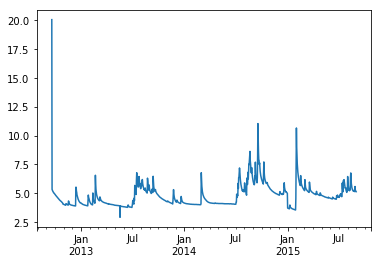

In [11]:
data["AirMOSS_L4_rootzone_mean"].plot()

---------------------------------------------
## Read USFS data from GeoJSON

The original dataset was a shapefile, but we reprojected and saved as GeoJSON using *ogr2ogr* from the GDAL/OGR binaries package available at OSGeo. GeoJSON is [a format for encoding a variety of geographic data structures](http://geojson.org/).

Let's open the GeoJSON and extract some information about one of the USFS sites. Read to a dictionary with `json.load` and print the first feature:

In [15]:
with open("docs/usfs_sites/Sites_lf_geo.json", "r") as f:
    shapes = json.load(f) # dict <- json text 

shapes.keys()

dict_keys(['type', 'name', 'crs', 'features'])

Inspect the first three dictionary items:

In [16]:
print(shapes["crs"]) 
print(shapes["name"])
print(shapes["type"])

{'type': 'name', 'properties': {'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'}}
Sites_lf_geo
FeatureCollection


A list of geojson features is stored in the *features* element. Print the keys for the first one:

In [17]:
features = shapes["features"]
feat = features[0]

feat.keys()

dict_keys(['type', 'properties', 'geometry'])

The geometry contains a list of coordinates that make the feature boundary. Here's an example:
```
 "type": "Feature",
   "geometry": {
       "type": "Polygon",
       "coordinates": [
           [
               [100.0, 0.0],
               [101.0, 0.0],
               [101.0, 1.0],
               [100.0, 1.0],
               [100.0, 0.0]
           ]
       ]
   },
```
A feature's properties are equivalent to what you'd find in the attribute table if you were to open the file in ArcMap. Print them:

In [18]:
feat["properties"]

{'OBJECTID': 61,
 'RANGERDIST': '99030501010343',
 'REGION': '03',
 'FORESTNUMB': '05',
 'DISTRICTNU': '01',
 'DISTRICTOR': '030501',
 'FORESTNAME': 'Coronado National Forest',
 'DISTRICTNA': 'Douglas Ranger District',
 'GIS_ACRES': 434025.2,
 'SHAPE_Leng': 3.96360236158,
 'SHAPE_Area': 0.16722952205,
 'Rowid_': 59,
 'FID_1': 60,
 'COUNT': 8159,
 'AREA': 509937500,
 'MIN': -79,
 'MAX': 34,
 'RANGE': 113,
 'MEAN': -42.6505699228,
 'STD': 15.107567792,
 'SUM': -347986,
 'VARIETY': 96,
 'MAJORITY': -51,
 'MINORITY': -79,
 'MEDIAN': -44,
 'Count_1': 8270,
 'Count_2': 8269,
 'Count_3': 8270,
 'Count_4': 8271,
 'Count_5': 8269,
 'Count_6': 8257,
 'Count_7': 8266,
 'Count_8': 8273,
 'Count_9': 8272,
 'Count_10': 8274,
 'Count_11': 8253,
 'Count_12': 8256,
 'Count_13': 8263,
 'Count_14': 8268,
 'Count_15': 8262,
 'Count_16': 8234,
 'Count_17': 8263,
 'Count_18': 8268,
 'Count_19': 8245,
 'Count_20': 8224,
 'Count_21': 8272,
 'Count_22': 8271,
 'Count_23': 8252,
 'Count_24': 8259,
 'Count_25': 

These values are aboveground NPP. Collect the values for mean and standard deviation into a dictionary, and make a data frame from the dictionary:

In [23]:
stats = pd.DataFrame({
    "mean": [v for k,v in feat["properties"].items() if "MEAN" in k],
    "std": [v for k,v in feat["properties"].items() if "STD" in k]})

stats.head(5)

,mean,std
0,-42.650570,15.107568
1,886.231560,569.668620
2,1182.049220,833.106219
3,1269.578235,813.900927
4,1307.410349,909.134138


Make a `Shapely.geometry.shape`:

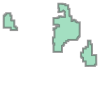

In [24]:
geom = feat["geometry"]         # geometry from feature 0
sgeom = shape(geom)             # Shapely.geometry.shape
bnds = sgeom.bounds             # bounding box around geometry
cent = sgeom.centroid           # centroid for geometry

sgeom

`Shapely` has convenient way to get some spatial metadata about the feature like the centroid and bounding coordinates.

* [ipywidgets](https://ipywidgets.readthedocs.io/en/stable/index.html) --- interactive HTML widgets for Jupyter Notebooks and the IPython kernel | [GitHub](https://github.com/jupyter-widgets/ipywidgets)
* [ipyleaflet](https://ipyleaflet.readthedocs.io/en/latest/) --- a Jupyter/Leaflet bridge enabling interactive maps inside  notebooks | [GitHub](https://github.com/jupyter-widgets/ipyleaflet)

After installing with *pip*, you need to enable the jupyter extensions:
```
pip install ipywidgets
pip install ipyleaflet
jupyter nbextension enable --py widgetsnbextension
```

For now, we learn how to render the geometry as an [`ipyleaflet`](https://ipyleaflet.readthedocs.io/en/latest/) map layer. Create the map in four steps:
1. Get a basemap and make a tile layer to display in the map widget. You have a lot of options, including layers available through NASA GIBS: `basemaps.NASAGIBS.ModisTerraTrueColorCR` | [More information](https://ipyleaflet.readthedocs.io/en/latest/api_reference/tile_layer.html)
2. [Make a map layer from the GeoJSON feature](https://ipyleaflet.readthedocs.io/en/latest/api_reference/geo_json.html) that we explored earlier.
3. Make an [`ipyleaflet.LayerGroup`](https://ipyleaflet.readthedocs.io/en/latest/api_reference/layer_group.html) to store an array of point layers that we will generate in the next step.
4. [Initialize the map widget](https://ipyleaflet.readthedocs.io/en/latest/api_reference/map.html) with a tuple of layers, the map center and zoom level.

In [25]:
bmap = mwg.basemap_to_tiles(mwg.basemaps.Esri.WorldImagery) # 1. get a basemap
poly = mwg.GeoJSON(data=feat)                               # 2. geojson layer
points = mwg.LayerGroup()                                   # 3. points group
m1 = mwg.Map(                                               # 4. map widget init
    layers=(bmap, poly, points,),  # tuple of map layers
    center=(cent.y, cent.x),       # map center (from shapely)
    zoom=9)                        # zoom level

m1                                 # display the map

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

## the EASE Grid

Soil Moisture Visualizer downloads require a lat/lon to select data from 9x9-km cells within [the EASE grid system](https://nsidc.org/data/ease).

The next section shows how to select an array coordinates that represent centroids of EASE grid cells that fall within the boundary of the `shapely` shape above. The coordinates can then be used to submit requests for SMV data.
      
The EASE grid latitudes and longitudes are stored in two binary files:
* [docs/EASE2_M09km.lats.3856x1624x1.double](docs/EASE2_M09km.lats.3856x1624x1.double)
* [docs/EASE2_M09km.lats.3856x1624x1.double](docs/EASE2_M09km.lats.3856x1624x1.double)

Read them to arrays with [`numpy.fromfile`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.fromfile.html), flatten them by calling [`numpy.ndarray.flatten`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.flatten.html), and stack them with [`numpy.dstack`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.dstack.html) to make one very long 2-d array of latitude, longitude pairs:

In [26]:
lats = np.fromfile("docs/EASE2_M09km.lats.3856x1624x1.double", dtype=np.float64).flatten() 
lons = np.fromfile("docs/EASE2_M09km.lons.3856x1624x1.double", dtype=np.float64).flatten()
crds = np.dstack((lats,lons))[0]

print("Array shape: "+str(crds.shape)); crds

Array shape: (6262144, 2)


array([[  84.6564188 , -179.9533195 ],
       [  84.6564188 , -179.85995851],
       [  84.6564188 , -179.76659751],
       ...,
       [ -84.6564188 ,  179.76659751],
       [ -84.6564188 ,  179.85995851],
       [ -84.6564188 ,  179.9533195 ]])

Reduce the giant array using the tuple of `bnds` that we took from the `shapely` geometry earlier:

In [27]:
ease = crds[(bnds[1]<lats)&(lats<bnds[3])&(bnds[0]<lons)&(lons<bnds[2])]

print("The new array shape: "+str(ease.shape))

The new array shape: (108, 2)


So, 108 EASE grid points fall within the minimum rectangular envelope of the geometry. That seems reasonable. Make an [`ipyleaflet.CircleMarker`](https://ipyleaflet.readthedocs.io/en/latest/api_reference/circle_marker.html) for each point and display the updated map widget:

In [28]:
for p in ease:
    pt = mwg.CircleMarker(                       # map point
        location=(p[0],p[1]),                    # lat,lon tuple
        radius=7,                                # in pixels
        stroke=False,
        fill_opacity=0.6,
        fill_color="black")
    points.add_layer(pt)
    
m1

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

Now eliminate points that fall outside of the actual boundary of the polygon. `shapely.geometry.shape` has a method [`object.contains`](https://shapely.readthedocs.io/en/stable/manual.html) that returns a boolean indicating whether or not it contains an the input x,y. The next cell does the following:
1. Clear the points that we added to the map in the last cell.
2. Make a simple function `get_point` that returns a `shapely.geometry.shape` for an input lat,lon pair.
3. Iterate over the remaining EASE grid points and add to the map widget if shapely *contains* returns True.

In [29]:
def get_point(p):
    """Takes input lat,lon pair; returns a shapely point geometry."""
    s = shape({"coordinates": [p[1], p[0]], "type": "Point"})
    return(s)


points.clear_layers()                   # clear the map points
for p in ease:                          # loop over remaining EASE points
    
    spt = get_point([p[0], p[1]])       # get a shapely point
    if sgeom.contains(spt):             # if poly contains point, 
        
        pt = mwg.CircleMarker(          # make circle marker
            location=(p[0],p[1]),
            radius=7,
            stroke=False,
            fill_opacity=0.6,
            fill_color="black")
        
        points.add_layer(pt)            # add to map
        
m1

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

Make a function that includes all of the logic above:

In [30]:
def get_ease(shapely_geom):
    """
    Takes an input shapely geometry and returns a list of EASE grid 
    lat,lon pairs that are contained within it.
    """

    bnds = shapely_geom.bounds                # bounding box of input geom
    ease = crds[
        (bnds[1]<lats) & (lats<bnds[3]) &     # ybnds < lat < ybnds
        (bnds[0]<lons) & (lons<bnds[2])]      # xbnds < lon < xbnds

    ease_reduced = []
    for p in ease:
        
        shapely_pt = shape({                  # input to shapely.shape is a
            "type": "Point",                  # python dict equivalent of
            "coordinates": (p[1], p[0])})     # geojson point geometry
        
        if shapely_geom.contains(shapely_pt): # if point inside poly
            ease_reduced.append([p[0], p[1]]) # return lat, lon tuple

    return(ease_reduced)

## Download SMV data with `requests`
Each request to SMV takes a latitude `&lt` and longitude `&ln`. This request is for (30,-100):       
https://daac.ornl.gov/cgi-bin/viz/download.pl?lt=30&ln=-100&d=smap

In [33]:
lt, ln = ease[0]                                               # first EASE point
url = "https://airmoss.ornl.gov/cgi-bin/viz/api/download.pl?"  # SMV download url
request_url = url+"lt={lt}&ln={ln}&d=smap".format(lt=lt,ln=ln) # complete request url

print("base url: "+url); print("full url: "+request_url)

base url: https://airmoss.ornl.gov/cgi-bin/viz/api/download.pl?
full url: https://airmoss.ornl.gov/cgi-bin/viz/api/download.pl?lt=32.0802909170736&ln=-110.02593360995849&d=smap


Now use [`requests.get`](https://2.python-requests.org//en/master/user/quickstart/) (*note: use `session` from the Earthdata authentication at the very beginning of the notebook*) to download the data from the URL and print the first ten lines:

In [36]:
r = session.get(request_url)
f = StringIO(r.text)

print("\n".join(f.readlines()[0:10]))

Filename: daily-smap-ORNL-DAAC-XXXXXX

Data_Set_Name: Daily soil moisture and ancillary datasets. Data columns are delineated by commas. The values in each column when separated by semicolons represent the daily range as 'min; mean; max'.

Location: 32.0802909170736, -110.02593360995849

Citation: ORNL DAAC. 2017. Soil Moisture Visualizer. ORNL DAAC, Oak Ridge, Tennessee, USA. http://dx.doi.org/10.3334/ORNLDAAC/1366





time,SoilSCAPE_surface,SoilSCAPE_rootzone,AirMOSS_L2_3_surface,AirMOSS_L2_3_rootzone,AirMOSS_L4_rootzone,SMAP_surface,SMAP_rootzone,NEE_mean,GPP_mean,prcp,tmax,tmin,ET,LST_Day,LST_Night,EVI,AirMOSS_in-ground_surface,AirMOSS_in-ground_rootzone,COSMOS_surface,COSMOS_rootzone,CRN_surface,CRN_rootzone,SCAN_surface,SCAN_rootzone,SNOTEL_surface,SNOTEL_rootzone,GRACE_surface_pctl,GRACE_rootzone_pctl

2002-04-01,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;0.72;,;2.92;

2002-04-02,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,

You can use the same methods that we covered at the beginning to parse the text to a pandas data frame. We will take that one step further in the next section as we prepare to add another dimension to our SMV dataset.

## Reformat SMV data as a netCDF-like `xarray.Dataset`

Now make an xarray dataset. Start with the two functions below, `txt_to_pd` and `split_pd`. They do all of the SMV data processing that we've covered to this to point: 
* convert the request response to a text object; 
* parse the text to a `pandas` data frame; and,
* parse the columns of `min;mean;max` into three new columns.

Test them on the dataset that we downloaded before:

In [37]:
def txt_to_pd(response_text):
    """Parses response.text to data frame with date index."""
    
    f = StringIO(response_text)                          # get file from string
    df = pd.read_csv(f, header=4, index_col="time")      # read to df
    df.index = pd.to_datetime(df.index)                  # convert index to dates
    
    return(df)


def split_pd(col):
    """Splits pd column by ; and set all values to float, nan."""
    
    df = col.str.split(";",n=2,expand=True)              # split col by ;
    df = df.replace('', np.nan)                          # set '' to nan
    df = df.astype(float)                                # set all to float
    df.columns = ["Min","Mean","Max"]                    # add column names
    
    return(df)

df = txt_to_pd(r.text)
df.index = pd.to_datetime(df.index)
dfs = {col: split_pd(df[col]) for col in df.columns}     # loop over cols and split to dfs

Make some *coordinate* variables that simplify indexing the data. This cell demonstrates how to make three [`xarray.DataArrays`](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.html#xarray.DataArray) that represent:
1. sample dimension --- lat,lon pairs organized along sample dimension
2. latitude dimension, 3. longitude dimension --- one pair per sample

In [39]:
latatts = dict(                                     # CF attributes for latitude
    standard_name="latitude",
    long_name="sample latitude",
    units="degrees_north")

lonatts = dict(                                     # CF attributes for longitude
    standard_name="latitude",
    long_name="sample latitude",
    units="degrees_north")

s = xr.DataArray(data=[1], dims=["sample"])                                  # 1. 
latarr = xr.DataArray(data=[lt], coords=[s], dims=["sample"], attrs=latatts) # 2.
lonarr = xr.DataArray(data=[ln], coords=[s], dims=["sample"], attrs=lonatts) # 3. 

latarr

<xarray.DataArray (sample: 1)>
array([32.080291])
Coordinates:
  * sample   (sample) int32 1
Attributes:
    standard_name:  latitude
    long_name:      sample latitude
    units:          degrees_north

The function below converts SMV downloads (as data frames) to an `xarray.DataArray` with three dimensions: the sample dimension (length=1), the time dimension (length=n), and the *stat* dimension, which really only exists because it allows us to keep all of the data in one place. Steps:

1. Collect from the SMV datasets table a list of attributes to assign to the array; 
2. convert the `pandas.DataFrame` to `xarray` 
3. rename the new dimension to "stat"; and, 
4. set new attribute that indicates whether or not there's valid data;

In [47]:
def pd_to_xr(dataset, df):
    """Makes an xr.Dataset from a pandas column (series) and coords."""
    
    a = smv_datasets.loc[dataset].to_dict()                 # 1.
    x = xr.DataArray(df, name=dataset, attrs=a)             # 2.
    x = x.rename(dict(dim_1="stat"))                        # 3.
    x.attrs["allnan"] = int(x.isnull().all())               # 4.
    
    return(x)

Loop over the dictionary of data frames, here's the first one:

In [48]:
ds = {c: pd_to_xr(c,d) for c,d in dfs.items()}
xds = xr.merge(ds.values())
xds = xds.assign_coords(lat=latarr, lon=lonarr)
xds

<xarray.Dataset>
Dimensions:                     (sample: 1, stat: 3, time: 6192)
Coordinates:
  * time                        (time) datetime64[ns] 2002-04-01 ... 2019-03-14
  * stat                        (stat) object 'Min' 'Mean' 'Max'
  * sample                      (sample) int32 1
    lat                         (sample) float64 32.08
    lon                         (sample) float64 -110.0
Data variables:
    SoilSCAPE_surface           (time, stat) float64 nan nan nan ... nan nan nan
    SoilSCAPE_rootzone          (time, stat) float64 nan nan nan ... nan nan nan
    AirMOSS_L2_3_surface        (time, stat) float64 nan nan nan ... nan nan nan
    AirMOSS_L2_3_rootzone       (time, stat) float64 nan nan nan ... nan nan nan
    AirMOSS_L4_rootzone         (time, stat) float64 nan nan nan ... nan nan nan
    SMAP_surface                (time, stat) float64 nan nan nan ... 24.15 24.98
    SMAP_rootzone               (time, stat) float64 nan nan nan ... 23.48 23.75
    NEE_mean     

And this is what a single SMV dataset looks like:

In [49]:
xds["SMAP_surface"]

<xarray.DataArray 'SMAP_surface' (time: 6192, stat: 3)>
array([[  nan,   nan,   nan],
       [  nan,   nan,   nan],
       [  nan,   nan,   nan],
       ...,
       [20.88, 26.94, 32.55],
       [25.8 , 28.44, 30.58],
       [21.9 , 24.15, 24.98]])
Coordinates:
  * time     (time) datetime64[ns] 2002-04-01 2002-04-02 ... 2019-03-14
  * stat     (stat) object 'Min' 'Mean' 'Max'
Attributes:
    source:         SMAP
    type:           spaceborne
    units:          m3/m3
    description:    Mean vol (%) soil moisture at 0-5cm 
    soil_zone:      surface
    soil_depth:     0-5, 0-100 cm
    native_res:     9000-m 
    time_coverage:  2015-present
    allnan:         0

Select data by dimension:

In [58]:
pds = xds.sel(stat="Mean", drop=True)
pds

<xarray.Dataset>
Dimensions:                     (sample: 1, time: 6192)
Coordinates:
  * time                        (time) datetime64[ns] 2002-04-01 ... 2019-03-14
  * sample                      (sample) int32 1
    lat                         (sample) float64 32.08
    lon                         (sample) float64 -110.0
Data variables:
    SoilSCAPE_surface           (time) float64 nan nan nan nan ... nan nan nan
    SoilSCAPE_rootzone          (time) float64 nan nan nan nan ... nan nan nan
    AirMOSS_L2_3_surface        (time) float64 nan nan nan nan ... nan nan nan
    AirMOSS_L2_3_rootzone       (time) float64 nan nan nan nan ... nan nan nan
    AirMOSS_L4_rootzone         (time) float64 nan nan nan nan ... nan nan nan
    SMAP_surface                (time) float64 nan nan nan ... 26.94 28.44 24.15
    SMAP_rootzone               (time) float64 nan nan nan ... 21.72 24.32 23.48
    NEE_mean                    (time) float64 nan nan nan ... 0.042 -0.007
    GPP_mean             

Pick variables by attribute with [`xarray.Dataset.filter_by_attrs`](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.filter_by_attrs.html#xarray.Dataset.filter_by_attrs):

In [52]:
pds.filter_by_attrs(units="m3/m3")

<xarray.Dataset>
Dimensions:        (time: 6192)
Coordinates:
  * time           (time) datetime64[ns] 2002-04-01 2002-04-02 ... 2019-03-14
Data variables:
    SMAP_surface   (time) float64 nan nan nan nan ... 18.42 26.94 28.44 24.15
    SMAP_rootzone  (time) float64 nan nan nan nan ... 20.69 21.72 24.32 23.48

In [53]:
units = list(set([pds[d].attrs["units"] for d in pds]))
print(units)

['m3/m3', 'g m-2 d-1', '%']


Text(0.5, 1.0, 'SMAP: Soil moisture at rootzone (1) and surface (2) depths; GPP and NEE (3)')

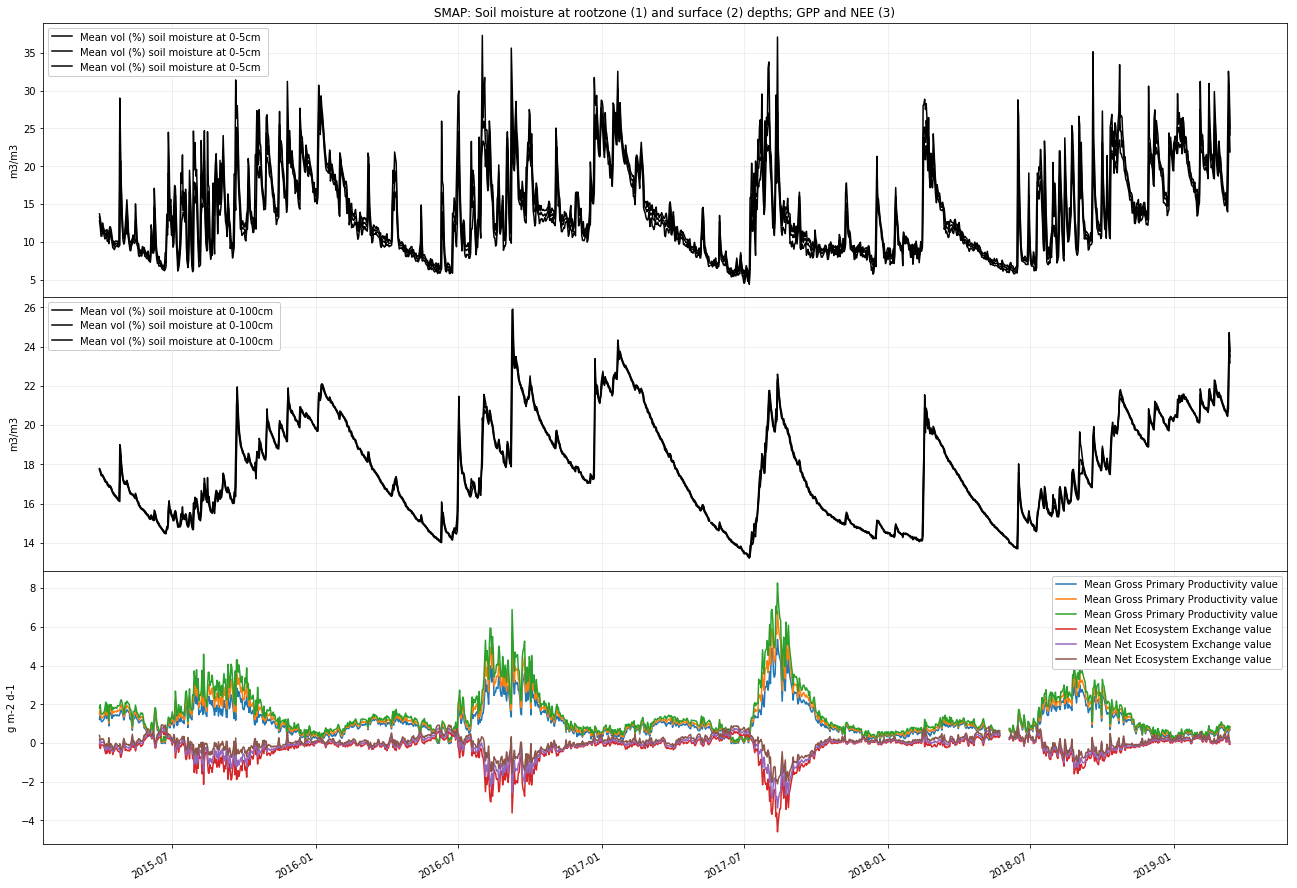

In [60]:
fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(18, 12))
fig.tight_layout()
plt.subplots_adjust(hspace=0.000)

smap = xds.filter_by_attrs(source="SMAP")                                        # get SMAP datasets

for p in [("SMAP_surface", 0, "black"), ("SMAP_rootzone", 1, "black"), 
          ("GPP_mean", 2, None), ("NEE_mean", 2, None)]:
    ax = axs[p[1]]
    data = smap[p[0]]
    desc = data.attrs["description"]
    
    data.plot.line(x="time", ax=ax, label=desc, add_legend=False, color=p[2])

for i, a in enumerate(axs):
    ylab = "m3/m3" if i<2 else "g m-2 d-1"
    a.set_ylabel(ylab)
    a.set_xlabel(None)
    a.grid('on', alpha=0.25)
    a.legend(loc=0, framealpha=1)
    
axs[0].set_title("SMAP: Soil moisture at rootzone (1) and surface (2) depths; GPP and NEE (3)")

We can also filter by any of the other attribute(s) that we assigned from the SMV datasets table:

In [61]:
pds.filter_by_attrs(source="SMAP", soil_zone="rootzone")

<xarray.Dataset>
Dimensions:        (time: 6192)
Coordinates:
  * time           (time) datetime64[ns] 2002-04-01 2002-04-02 ... 2019-03-14
Data variables:
    SMAP_rootzone  (time) float64 nan nan nan nan ... 20.69 21.72 24.32 23.48

### Slice/filter using dimension-based criteria
the *time* dimension:

In [63]:
time = pds.time.data
print(time[10]); print(time[20])

pds.sel(time=slice(time[10],time[20]))

2002-04-11T00:00:00.000000000
2002-04-21T00:00:00.000000000


<xarray.Dataset>
Dimensions:                     (sample: 1, time: 11)
Coordinates:
  * time                        (time) datetime64[ns] 2002-04-11 ... 2002-04-21
  * sample                      (sample) int32 1
    lat                         (sample) float64 32.08
    lon                         (sample) float64 -110.0
Data variables:
    SoilSCAPE_surface           (time) float64 nan nan nan nan ... nan nan nan
    SoilSCAPE_rootzone          (time) float64 nan nan nan nan ... nan nan nan
    AirMOSS_L2_3_surface        (time) float64 nan nan nan nan ... nan nan nan
    AirMOSS_L2_3_rootzone       (time) float64 nan nan nan nan ... nan nan nan
    AirMOSS_L4_rootzone         (time) float64 nan nan nan nan ... nan nan nan
    SMAP_surface                (time) float64 nan nan nan nan ... nan nan nan
    SMAP_rootzone               (time) float64 nan nan nan nan ... nan nan nan
    NEE_mean                    (time) float64 nan nan nan nan ... nan nan nan
    GPP_mean                